In [48]:
import warnings
warnings.filterwarnings("ignore")

import glob
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pywt import wavedec
import pywt
from scipy.signal import butter, filtfilt
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from scipy import signal
from scipy.signal import periodogram

In [49]:
!pip install seaborn

In [50]:
train_data="C:/Users/LENOVO/Downloads/class-20250510T171956Z-1-001/class/Train"
test_data="C:/Users/LENOVO/Downloads/class-20250510T171956Z-1-001/class/Test"
horizontal_file_train="data_train_h.csv"
vertical_file_train="data_train_v.csv"
horizontal_file_test="data_test_h.csv"
vertical_file_test="data_test_v.csv"
def read_and_process_signal_files(root_dir, horizontal_file, vertical_file):
    # Map folder names to labels
    class_labels = {
        'up': 0,
        'down': 1,
        'right': 2,
        'left': 3,
        'blink': 4
    }

    # Counters
    sample_counts = {label: 0 for label in class_labels.values()}
    skipped_files = []

    with open(horizontal_file, 'w') as csv_h, open(vertical_file, 'w') as csv_v:
        # Loop over each subfolder
        for subdir_name in os.listdir(root_dir):
            subdir_path = os.path.join(root_dir, subdir_name)
            if not os.path.isdir(subdir_path):
                continue

            class_key = subdir_name.lower()
            if class_key not in class_labels:
                print(f"Skipping unknown class folder: {subdir_name}")
                continue

            label = class_labels[class_key]

            # Search for horizontal signal files
            h_files = glob.glob(os.path.join(subdir_path, "*h.txt"))

            for h_file in h_files:
                v_file = h_file.replace('h.txt', 'v.txt')
                if not os.path.exists(v_file):
                    print(f"Missing v.txt for: {h_file}")
                    skipped_files.append((h_file, "missing v.txt"))
                    continue

                try:
                    with open(h_file, 'r') as f_h, open(v_file, 'r') as f_v:
                        h_raw = f_h.read().strip()
                        v_raw = f_v.read().strip()

                        if not h_raw or not v_raw:
                            print(f"Skipping empty file(s): {h_file}, {v_file}")
                            skipped_files.append((h_file, "empty file"))
                            continue

                        h_lines = h_raw.replace('\n', ',').strip(',')
                        v_lines = v_raw.replace('\n', ',').strip(',')

                        # Debug print
                        print(f"Processing: {h_file}, Label: {label}")

                        # Write to CSVs
                        csv_h.write(h_lines + ',' + str(label) + '\n')
                        csv_v.write(v_lines + ',' + str(label) + '\n')

                        sample_counts[label] += 1
                        print(f"Saved: {os.path.basename(h_file)} and {os.path.basename(v_file)} — Label {label}")

                except Exception as e:
                    print(f"Error reading files: {h_file}, {v_file}\n{e}")
                    skipped_files.append((h_file, str(e)))

    # Summary
    print("\n=== Summary ===")
    for label, count in sample_counts.items():
        class_name = [k for k, v in class_labels.items() if v == label][0]
        print(f"{class_name} ({label}): {count} samples")

    if skipped_files:
        print("\nSkipped file details:")
        for file, reason in skipped_files:
            print(f"{file} — {reason}")

    # Load CSVs into DataFrames
    df_h = pd.read_csv(horizontal_file, header=None)
    df_v = pd.read_csv(vertical_file, header=None)

    # Display label distribution
    Y_h = df_h.iloc[:, -1]
    Y_v = df_v.iloc[:, -1]

    print(f"\nUnique labels in Y_h: {Y_h.unique()}")
    print(f"Unique labels in Y_v: {Y_v.unique()}")

    print("\nSample count per label (horizontal):")
    print(Y_h.value_counts())

    print("\nSample count per label (vertical):")
    print(Y_v.value_counts())

    return df_h, df_v
dfTrain_h, dfTrain_v = read_and_process_signal_files(train_data,horizontal_file_train,vertical_file_train)
dfTest_h, dfTest_v=read_and_process_signal_files(test_data,horizontal_file_test,vertical_file_test)

Processing: C:/Users/LENOVO/Downloads/class-20250510T171956Z-1-001/class/Train\Blink\kirp10h.txt, Label: 4
Saved: kirp10h.txt and kirp10v.txt — Label 4
Processing: C:/Users/LENOVO/Downloads/class-20250510T171956Z-1-001/class/Train\Blink\kirp11h.txt, Label: 4
Saved: kirp11h.txt and kirp11v.txt — Label 4
Processing: C:/Users/LENOVO/Downloads/class-20250510T171956Z-1-001/class/Train\Blink\kirp12h.txt, Label: 4
Saved: kirp12h.txt and kirp12v.txt — Label 4
Processing: C:/Users/LENOVO/Downloads/class-20250510T171956Z-1-001/class/Train\Blink\kirp13h.txt, Label: 4
Saved: kirp13h.txt and kirp13v.txt — Label 4
Processing: C:/Users/LENOVO/Downloads/class-20250510T171956Z-1-001/class/Train\Blink\kirp14h.txt, Label: 4
Saved: kirp14h.txt and kirp14v.txt — Label 4
Processing: C:/Users/LENOVO/Downloads/class-20250510T171956Z-1-001/class/Train\Blink\kirp15h.txt, Label: 4
Saved: kirp15h.txt and kirp15v.txt — Label 4
Processing: C:/Users/LENOVO/Downloads/class-20250510T171956Z-1-001/class/Train\Blink\kir

In [51]:

# Split into features and labels
X_h_train = dfTrain_h.iloc[:, :-1]  # All columns except the last
X_v_train = dfTrain_v.iloc[:, :-1] 
Y_h_train = dfTrain_h.iloc[:, -1].astype(int)  # Last column as integer labels
Y_v_train = dfTrain_v.iloc[:, -1].astype(int)

# Show shapes
print("\nX_h shape:", X_h_train.shape)
print("X_v shape:", X_v_train.shape)

# Show unique labels
print("\nUnique labels in Y_h:", Y_h_train.unique())
print("Unique labels in Y_v:", Y_v_train.unique())

# Count samples per label
print("\nSample count per label (horizontal):")
print(Y_h_train.value_counts().sort_index())

print("\nSample count per label (vertical):")
print(Y_v_train.value_counts().sort_index())



X_h shape: (80, 251)
X_v shape: (80, 251)

Unique labels in Y_h: [4 1 3 2 0]
Unique labels in Y_v: [4 1 3 2 0]

Sample count per label (horizontal):
251
0    16
1    16
2    16
3    16
4    16
Name: count, dtype: int64

Sample count per label (vertical):
251
0    16
1    16
2    16
3    16
4    16
Name: count, dtype: int64


In [52]:
# Split into features and labels
X_h_test = dfTest_h.iloc[:, :-1]  # All columns except the last
X_v_test = dfTest_v.iloc[:, :-1] 
Y_h_test = dfTest_h.iloc[:, -1].astype(int)  # Last column as integer labels
Y_v_test = dfTest_v.iloc[:, -1].astype(int)

# Show shapes
print("\nX_h shape:", X_h_test.shape)
print("X_v shape:", X_v_test.shape)

# Show unique labels
print("\nUnique labels in Y_h:", Y_h_test.unique())
print("Unique labels in Y_v:", Y_v_test.unique())

# Count samples per label
print("\nSample count per label (horizontal):")
print(Y_h_test.value_counts().sort_index())

print("\nSample count per label (vertical):")
print(Y_v_test.value_counts().sort_index())


X_h shape: (20, 251)
X_v shape: (20, 251)

Unique labels in Y_h: [4 1 3 2 0]
Unique labels in Y_v: [4 1 3 2 0]

Sample count per label (horizontal):
251
0    4
1    4
2    4
3    4
4    4
Name: count, dtype: int64

Sample count per label (vertical):
251
0    4
1    4
2    4
3    4
4    4
Name: count, dtype: int64


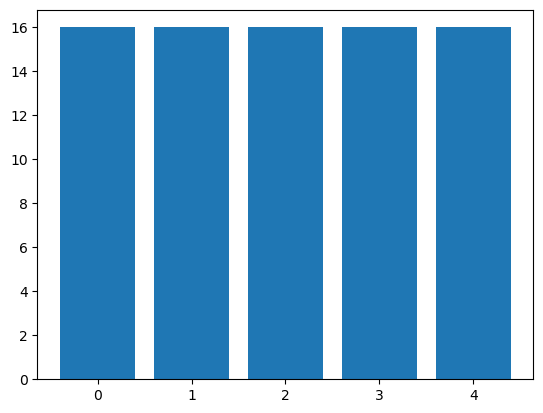

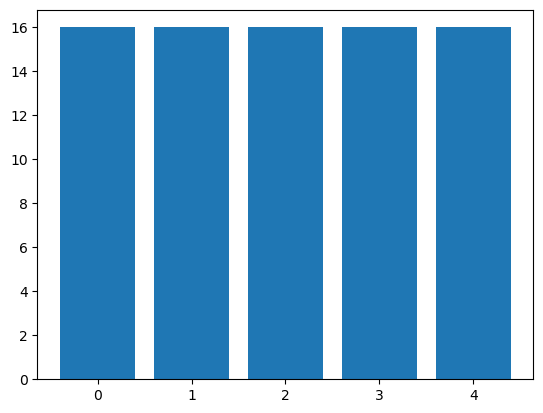

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram
y_h = Y_h_train.astype(str)
y_v=Y_v_train.astype(str)
plt.bar(Y_h_train.unique(), y_h.value_counts())
plt.show()
plt.bar(Y_v_train.unique(), y_v.value_counts())
plt.show()

## PreProcessing

In [54]:
def butter_bandpass_filter(Input_Signal,LOW_Cutoff,High_cuttOff,Sampling_Rate,order):
    nyq = 0.5 *Sampling_Rate
    low = LOW_Cutoff/ nyq
    high = High_cuttOff / nyq
    Numerator,denominator = butter(order,[low,high],btype = "band",output = "ba",analog = False,fs = None)
    filtered = filtfilt(Numerator,denominator,Input_Signal)
    return filtered

def resample_filter(Filtered_Data):
    resampled_Signal = []
    for i in Filtered_Data:
        re_Sgnl = signal.resample(i,50)
        resampled_Signal.append(re_Sgnl)
    return resampled_Signal

def remove_dc(signal_array):
    return signal_array - np.mean(signal_array, axis=1, keepdims=True)

# 4. Normalization (Z-score)
def normalize(signal_array):
    mean = np.mean(signal_array, axis=1, keepdims=True)
    std = np.std(signal_array, axis=1, keepdims=True)
    return (signal_array - mean) / std


filtered_Signal_h_train = butter_bandpass_filter(X_h_train,LOW_Cutoff=0.5,High_cuttOff=20,Sampling_Rate=176,order=2)
filtered_Signal_v_train = butter_bandpass_filter(X_v_train,LOW_Cutoff=0.5,High_cuttOff=20,Sampling_Rate=176,order=2)
filtered_Signal_h_test = butter_bandpass_filter(X_h_test,LOW_Cutoff=0.5,High_cuttOff=20,Sampling_Rate=176,order=2)
filtered_Signal_v_test = butter_bandpass_filter(X_v_test,LOW_Cutoff=0.5,High_cuttOff=20,Sampling_Rate=176,order=2)

X_train_combined = np.concatenate((filtered_Signal_h_train, filtered_Signal_v_train), axis=1)
X_test_combined = np.concatenate((filtered_Signal_h_test, filtered_Signal_v_test), axis=1)

# Final check
print("Train Combined Shape:", X_train_combined.shape)
print("Test Combined Shape:", X_test_combined.shape)

print(Y_h_train.shape)



Train Combined Shape: (80, 502)
Test Combined Shape: (20, 502)
(80,)


## Raw Feature SVM

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

✅ SVM Train Accuracy: 1.0000
✅ SVM Test Accuracy: 0.8500

Classification Report (Test):
              precision    recall  f1-score   support

          up       0.75      0.75      0.75         4
        down       0.80      1.00      0.89         4
       right       1.00      0.75      0.86         4
        left       0.80      1.00      0.89         4
       blink       1.00      0.75      0.86         4

    accuracy                           0.85        20
   macro avg       0.87      0.85      0.85        20
weighted avg       0.87      0.85      0.85        20



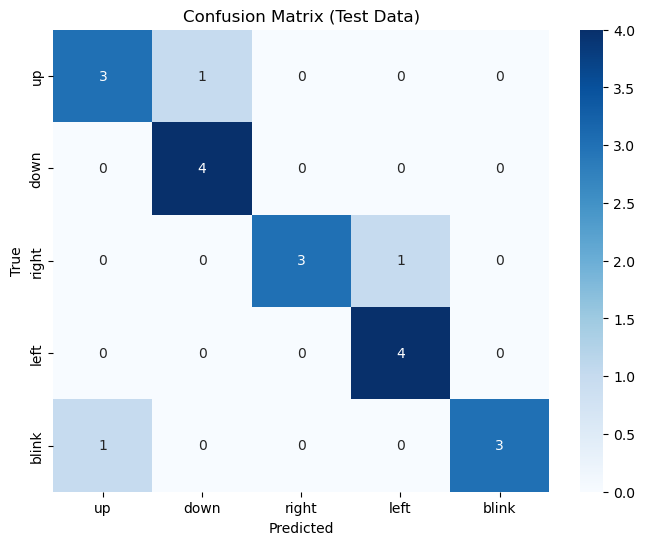

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Define parameter grid for GridSearch
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf']  # You can add other kernels like 'linear', 'poly', etc., if needed
}

# Step 2: Set up the GridSearchCV with cross-validation
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Step 3: Fit the model with the training data
grid_search.fit(X_train_combined, Y_h_train)

# Step 4: Get the best parameters from the GridSearch
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Step 5: Train the SVM model with the best parameters
svm_model_best = grid_search.best_estimator_

# Step 6: Predict on training data
y_train_pred = svm_model_best.predict(X_train_combined)
train_accuracy = accuracy_score(Y_h_train, y_train_pred)
print(f"\n✅ SVM Train Accuracy: {train_accuracy:.4f}")

# Step 7: Predict on test data
y_test_pred = svm_model_best.predict(X_test_combined)
test_accuracy = accuracy_score(Y_h_test, y_test_pred)
print(f"✅ SVM Test Accuracy: {test_accuracy:.4f}")

# Step 8: Detailed classification report
print("\nClassification Report (Test):")
print(classification_report(Y_h_test, y_test_pred, target_names=['up', 'down', 'right', 'left', 'blink']))

# Step 9: Confusion matrix
cm = confusion_matrix(Y_h_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['up', 'down', 'right', 'left', 'blink'],
            yticklabels=['up', 'down', 'right', 'left', 'blink'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Data)')
plt.show()


In [56]:
import joblib
joblib.dump(svm_model_best, 'C:/Users/LENOVO/Downloads/Raw_Feature_Model.joblib')


['C:/Users/LENOVO/Downloads/Raw_Feature_Model.joblib']

# Morphological Feature

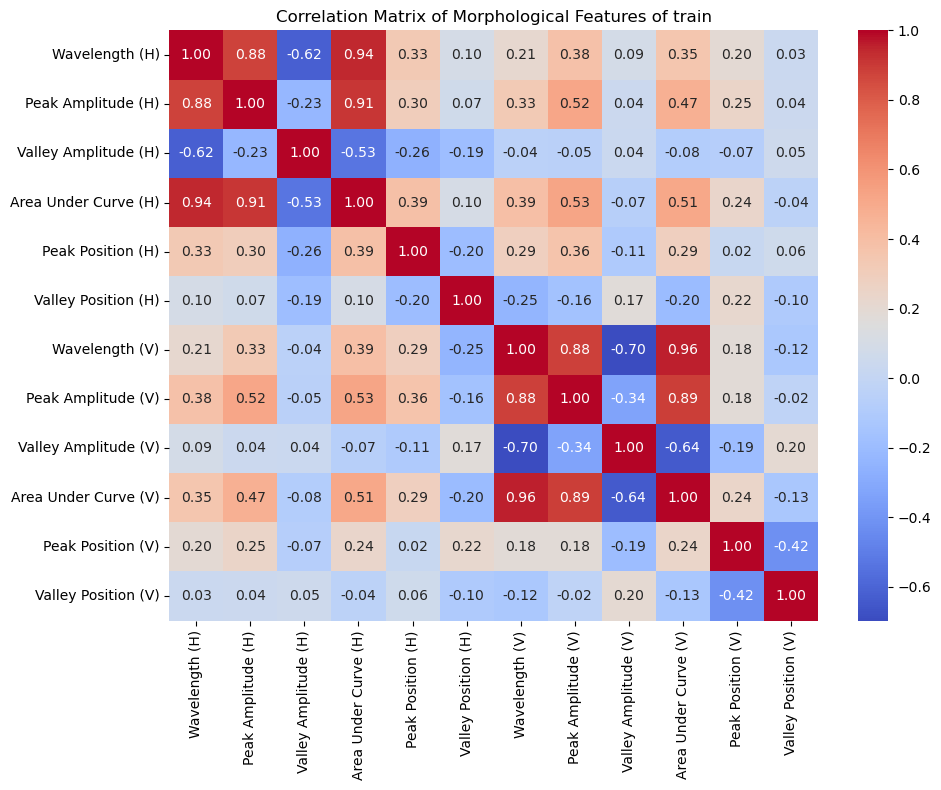

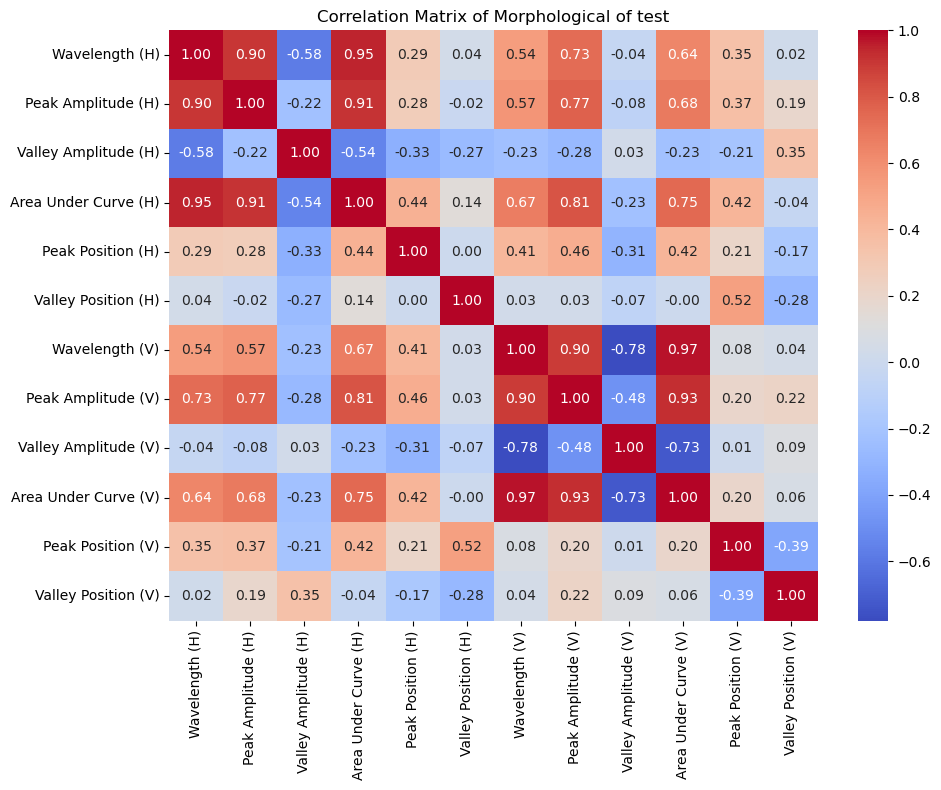

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ---------- Morphological Feature Extraction ----------
def extract_morphological_features(signal_data):
    features = []
    for signal in signal_data:
        # Wavelength
        wavelength = np.sum(np.abs(np.diff(signal)))

        # Peaks and valleys
        peaks, _ = find_peaks(signal)
        valleys, _ = find_peaks(-signal)

        # Peak amplitude and position
        if peaks.size > 0:
            peak_idx = np.argmax(signal[peaks])
            peak_amp = signal[peaks[peak_idx]]
            peak_pos = peaks[peak_idx]
        else:
            peak_amp = 0
            peak_pos = 0

        # Valley amplitude and position
        if valleys.size > 0:
            valley_idx = np.argmin(signal[valleys])
            valley_amp = signal[valleys[valley_idx]]
            valley_pos = valleys[valley_idx]
        else:
            valley_amp = 0
            valley_pos = 0

        # Area under curve (absolute)
        area = np.trapz(np.abs(signal))

        # Append all features
        features.append([
            wavelength, peak_amp, valley_amp, area,
            peak_pos, valley_pos
        ])
    return np.array(features)


# ---------- Replace these with your actual signal arrays ----------
# Example: filtered_Signal_h_train = [np.array([...]), np.array([...]), ...]
# Make sure both have the same length
# filtered_Signal_h_train = ...
# filtered_Signal_v_train = ...

# ---------- Feature Extraction ----------
h_features_train = extract_morphological_features(filtered_Signal_h_train)
v_features_train = extract_morphological_features(filtered_Signal_v_train)

h_features_test = extract_morphological_features(filtered_Signal_h_test)
v_features_test = extract_morphological_features(filtered_Signal_v_test)
# Combine horizontal and vertical features
morph_features_train = np.concatenate([h_features_train, v_features_train], axis=1)
morph_features_test = np.concatenate([h_features_test, v_features_test], axis=1)

# Feature labels
columns = [
    'Wavelength (H)', 'Peak Amplitude (H)', 'Valley Amplitude (H)', 'Area Under Curve (H)','Peak Position (H)','Valley Position (H)',
    'Wavelength (V)', 'Peak Amplitude (V)', 'Valley Amplitude (V)', 'Area Under Curve (V)','Peak Position (V)','Valley Position (V)'
]

morph_df_train = pd.DataFrame(morph_features_train, columns=columns)
morph_df_test = pd.DataFrame(morph_features_test, columns=columns)

# ---------- Correlation Matrix ----------
plt.figure(figsize=(10, 8))
sns.heatmap(morph_df_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Morphological Features of train")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(morph_df_test.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Morphological of test")
plt.tight_layout()
plt.show()

# ---------- PCA Analysis ----------
# scaler = StandardScaler()
# scaled_features_train = scaler.fit_transform(morph_df_train)
# scaled_features_test = scaler.fit_transform(morph_df_test)
# pca = PCA(n_components=8)
# pca_features_train = pca.fit_transform(scaled_features_train)
# pca_features_test= pca.fit_transform(scaled_features_test)

# # Explained variance
# plt.figure(figsize=(8, 5))
# plt.bar(range(1, 9), pca.explained_variance_ratio_, alpha=0.7, color='teal', edgecolor='black')
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.title('PCA - Explained Variance by Component')
# plt.xticks(range(1, 9))
# plt.tight_layout()
# plt.show()

# # Cumulative variance
# cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, 9), cumulative_variance, marker='o', linestyle='-', color='darkgreen')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Cumulative Explained Variance (PCA)')
# plt.grid(True)
# plt.tight_layout()
# plt.show()




# insights
## Area under the curve is highly correlated with wavelength and peak Amplitude
## wavelength and peak Amplitude also highly correlated then i will keep only one feature

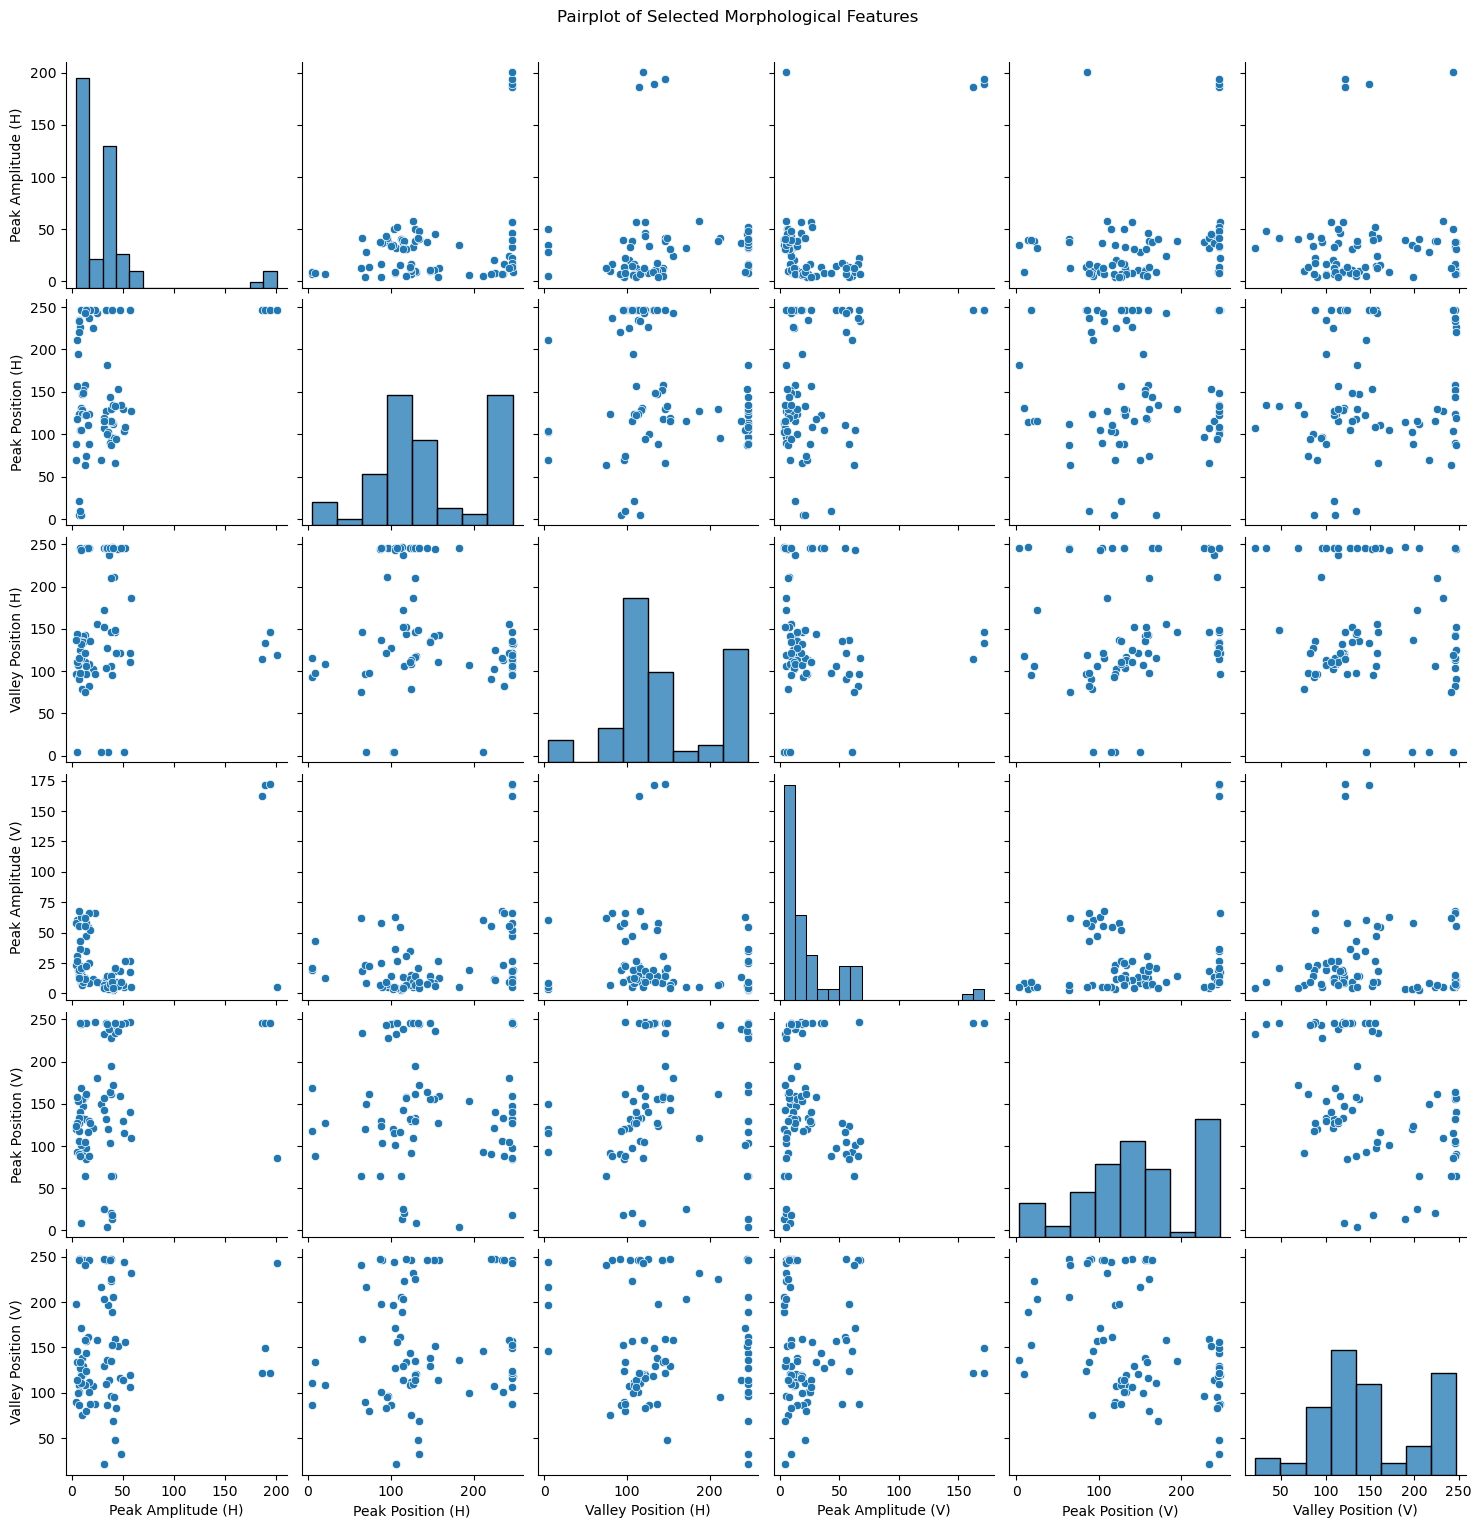

   Peak Amplitude (H)  Peak Position (H)  Valley Position (H)  \
0           40.503606              112.0                246.0   
1           39.441643              114.0                247.0   
2           31.729546              107.0                246.0   
3           37.840697               97.0                246.0   
4           35.153000              103.0                  4.0   

   Peak Amplitude (V)  Peak Position (V)  Valley Position (V)  
0            3.150216               64.0                205.0  
1            3.651860               14.0                189.0  
2            4.712432              233.0                 21.0  
3            4.881685              228.0                 96.0  
4            3.688810              120.0                197.0  


In [70]:
selected_columns = ['Peak Amplitude (H)', 'Peak Position (H)','Valley Position (H)', 'Peak Amplitude (V)','Peak Position (V)','Valley Position (V)']
selected_features_df_train = morph_df_train[selected_columns]
selected_features_df_test = morph_df_test[selected_columns]
sns.pairplot(selected_features_df_train)
plt.suptitle('Pairplot of Selected Morphological Features', y=1.02)
plt.show()

print(selected_features_df_train.head())


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

✅ SVM Train Accuracy: 98.7500 %
✅ SVM Test Accuracy: 95.0000 %

Classification Report (Test):
              precision    recall  f1-score   support

          up       0.80      1.00      0.89         4
        down       1.00      1.00      1.00         4
       right       1.00      1.00      1.00         4
        left       1.00      1.00      1.00         4
       blink       1.00      0.75      0.86         4

    accuracy                           0.95        20
   macro avg       0.96      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20



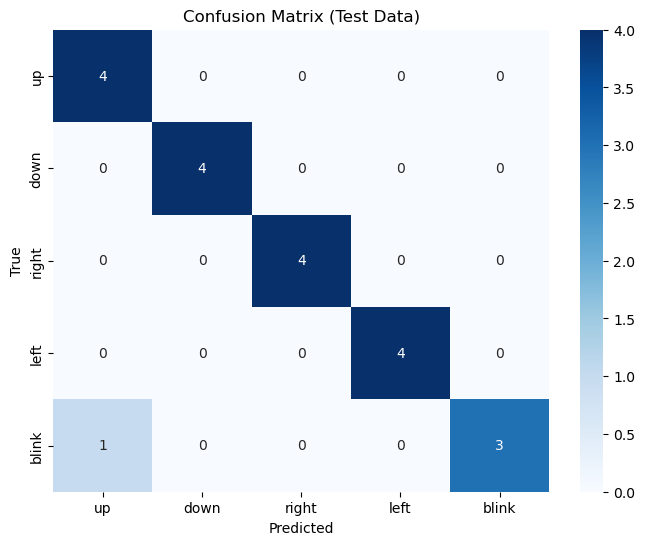

In [73]:
from sklearn.model_selection import GridSearchCV

# Step 1: Define parameter grid for GridSearch
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf']  # You can add other kernels like 'linear', 'poly', etc., if needed
}

# Step 2: Set up the GridSearchCV with cross-validation
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Step 3: Fit the model with the training data
grid_search.fit(selected_features_df_train, Y_h_train)

# Step 4: Get the best parameters from the GridSearch
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Step 5: Train the SVM model with the best parameters
svm_model_best = grid_search.best_estimator_

# Step 6: Predict on training data
y_train_pred = svm_model_best.predict(selected_features_df_train)
train_accuracy = accuracy_score(Y_h_train, y_train_pred)
print(f"\n✅ SVM Train Accuracy: {train_accuracy*100:.4f} %")

# Step 7: Predict on test data
y_test_pred = svm_model_best.predict(selected_features_df_test)
test_accuracy = accuracy_score(Y_h_test, y_test_pred)
print(f"✅ SVM Test Accuracy: {test_accuracy*100:.4f} %")

# Step 8: Detailed classification report
print("\nClassification Report (Test):")
print(classification_report(Y_h_test, y_test_pred, target_names=['up', 'down', 'right', 'left', 'blink']))

# Step 9: Confusion matrix
cm = confusion_matrix(Y_h_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['up', 'down', 'right', 'left', 'blink'],
            yticklabels=['up', 'down', 'right', 'left', 'blink'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Data)')
plt.show()


In [60]:
print("selected_features_df_test shape:", selected_features_df_test.shape)
print("Y_h_test shape:", Y_h_test.shape)
print("selected_features_df_test shape:", selected_features_df_train.shape)

selected_features_df_test shape: (20, 6)
Y_h_test shape: (20,)
selected_features_df_test shape: (80, 6)


In [61]:
!pip install joblib 

In [74]:
joblib.dump(svm_model_best, 'C:/Users/LENOVO/Downloads/Morphological Feature model.joblib')

['C:/Users/LENOVO/Downloads/Morphological Feature model.joblib']

In [62]:
!pip install statsmodels

In [63]:
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

def extract_ar_features(data, order=4):
    """
    Extract AR coefficients from each trial (channel-wise).
    data: 2D array, shape (n_trials, n_samples)
    order: AR order (number of lags)
    Returns: array of AR coefficients for each trial
    """
    ar_features = []
    for trial in data:
        model = AutoReg(trial, lags=order, old_names=False)
        model_fit = model.fit()
        ar_coeffs = model_fit.params[1:]  # skip intercept
        ar_features.append(ar_coeffs)
    return np.array(ar_features)
ar_order = 4  # or any other reasonable value

# Extract AR features from both horizontal and vertical signals
ar_h_train = extract_ar_features(filtered_Signal_h_train, order=ar_order)
ar_v_train = extract_ar_features(filtered_Signal_v_train, order=ar_order)

ar_h_test = extract_ar_features(filtered_Signal_h_test, order=ar_order)
ar_v_test = extract_ar_features(filtered_Signal_v_test, order=ar_order)

# Concatenate horizontal and vertical AR features
X_train_ar = np.concatenate((ar_h_train, ar_v_train), axis=1)
X_test_ar = np.concatenate((ar_h_test, ar_v_test), axis=1)

print("AR Feature Shape (Train):", X_train_ar.shape)
print("AR Feature Shape (Test):", X_test_ar.shape)


AR Feature Shape (Train): (80, 8)
AR Feature Shape (Test): (20, 8)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

✅ SVM Train Accuracy: 0.7750
✅ SVM Test Accuracy: 0.7500

Classification Report (Test):
              precision    recall  f1-score   support

          up       0.80      1.00      0.89         4
        down       0.80      1.00      0.89         4
       right       0.50      0.25      0.33         4
        left       0.60      0.75      0.67         4
       blink       1.00      0.75      0.86         4

    accuracy                           0.75        20
   macro avg       0.74      0.75      0.73        20
weighted avg       0.74      0.75      0.73        20



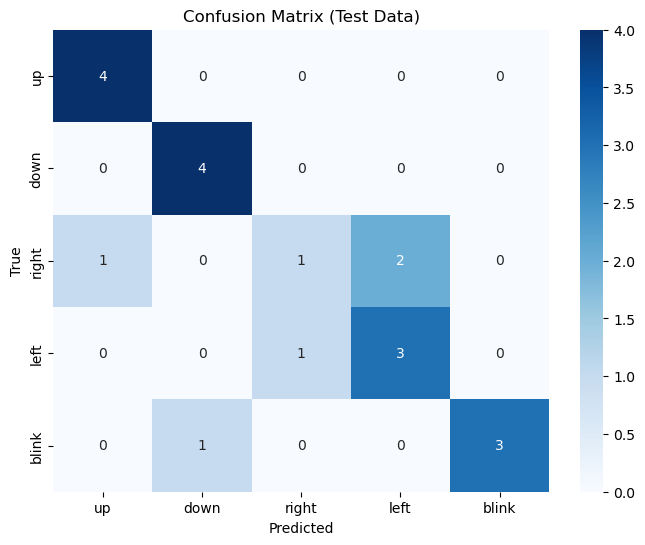

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Define parameter grid for GridSearch
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf']  # You can add other kernels like 'linear', 'poly', etc., if needed
}

# Step 2: Set up the GridSearchCV with cross-validation
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Step 3: Fit the model with the training data
grid_search.fit(X_train_ar, Y_h_train)

# Step 4: Get the best parameters from the GridSearch
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Step 5: Train the SVM model with the best parameters
svm_model_best = grid_search.best_estimator_

# Step 6: Predict on training data
y_train_pred = svm_model_best.predict(X_train_ar)
train_accuracy = accuracy_score(Y_h_train, y_train_pred)
print(f"\n✅ SVM Train Accuracy: {train_accuracy:.4f}")

# Step 7: Predict on test data
y_test_pred = svm_model_best.predict(X_test_ar)
test_accuracy = accuracy_score(Y_h_test, y_test_pred)
print(f"✅ SVM Test Accuracy: {test_accuracy:.4f}")

# Step 8: Detailed classification report
print("\nClassification Report (Test):")
print(classification_report(Y_h_test, y_test_pred, target_names=['up', 'down', 'right', 'left', 'blink']))

# Step 9: Confusion matrix
cm = confusion_matrix(Y_h_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['up', 'down', 'right', 'left', 'blink'],
            yticklabels=['up', 'down', 'right', 'left', 'blink'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Data)')
plt.show()
